In [ ]:
import warnings
from collections import Counter
import matplotlib.pyplot as plt
import torchvision
import torchvision.models as models
from torchvision.models import ViT_B_16_Weights
from torch.utils.data import Subset
from tqdm import tqdm
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
warnings.filterwarnings('ignore')
import torch
import pickle
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import time
import os
from PIL import Image
import torchvision.transforms as transforms
import spacy
import numpy as np
import torch.nn as nn
torch.backends.cudnn.benchmark = True

In [1]:

# Define image preprocessing pipeline
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


def preprocess_image(image_path):
    try:
        image = Image.open(image_path).convert('RGB')
        return image_transform(image)
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None

In [13]:

image_dir = r'D:\Projects\AIniverse\Scene_Description_Generator\flickr30k\versions\1\Images'
annotation_file = r'D:\Projects\AIniverse\Scene_Description_Generator\flickr30k\versions\1\captions.txt'

# Check images
print(f"Images found: {len(os.listdir(image_dir))}")  # Expected: ~31,783
# Check captions
df = pd.read_csv(annotation_file, sep=',', names=['image', 'caption'], skiprows=1)
print(f"Captions found: {len(df)}")  # Expected: ~158,915
print(df.head())  # Should show image-caption pairs like your example

Images found: 31784
Captions found: 158915
            image                                            caption
0  1000092795.jpg   Two young guys with shaggy hair look at their...
1  1000092795.jpg   Two young , White males are outside near many...
2  1000092795.jpg   Two men in green shirts are standing in a yard .
3  1000092795.jpg       A man in a blue shirt standing in a garden .
4  1000092795.jpg            Two friends enjoy time spent together .


In [14]:

tensor = preprocess_image(r'D:\Projects\AIniverse\Scene_Description_Generator\flickr30k\versions\1\Images\36979.jpg')
if tensor is not None:
    print(tensor.shape)  # Expected: torch.Size([3, 224, 224])

tensor = preprocess_image(r'D:\Projects\AIniverse\Scene_Description_Generator\flickr30k\versions\1\Images\36979.jpg')
if tensor is not None:
    torchvision.utils.save_image(tensor, 'preprocessed_image.jpg')

torch.Size([3, 224, 224])


torch.Size([3, 224, 224])


In [15]:

# Image preprocessing
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


def preprocess_image(image_path):
    try:
        image = Image.open(image_path).convert('RGB')
        return image_transform(image)
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None


# Load spaCy model once globally
nlp = spacy.load('en_core_web_sm')


# Use this updated and safe function
def preprocess_caption(captions, batch_size=1000):
    # Normalize to list
    if captions is None or isinstance(captions, float):
        captions = ['']
    elif isinstance(captions, str):
        captions = [captions]
    elif not isinstance(captions, list):
        raise TypeError(f"Expected string or list of strings, got {type(captions)}")

    # Strip and lowercase all valid entries
    clean_captions = [str(c).strip() for c in captions if isinstance(c, (str, float, int))]

    results = []
    for i in range(0, len(clean_captions), batch_size):
        batch = clean_captions[i:i + batch_size]
        docs = nlp.pipe([text.lower() for text in batch], disable=['parser', 'ner'])
        for doc in docs:
            tokens = [token.text for token in doc if not token.is_punct and token.text.strip()]
            results.append(tokens)

    return results if len(results) > 1 else results[0]


# Test
caption = "A dog is running in the park."
print(preprocess_caption(caption))  # Expected: ['a', 'dog', 'is', 'running', 'in', 'the', 'park']
captions = ["A dog is running in the park.", "A cat sleeps on a mat."]
print(preprocess_caption(
    captions))  # Expected: [['a', 'dog', 'is', 'running', 'in', 'the', 'park'], ['a', 'cat', 'sleeps', 'on', 'a', 'mat']]

['a', 'dog', 'is', 'running', 'in', 'the', 'park']
[['a', 'dog', 'is', 'running', 'in', 'the', 'park'], ['a', 'cat', 'sleeps', 'on', 'a', 'mat']]


In [16]:


class Flickr30kDataset(Dataset):
    def __init__(self, image_dir, annotation_file, image_transform=None):
        self.df = pd.read_csv(annotation_file, sep=',', names=['image', 'caption'], skiprows=1)
        self.image_dir = image_dir
        self.image_transform = image_transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_name = row['image']
        caption = row['caption']

        img_path = os.path.join(self.image_dir, img_name)
        image = preprocess_image(img_path)
        if image is None:
            return None

        caption_tokens = preprocess_caption(caption)
        return image, caption_tokens


# Custom collate function
def custom_collate_fn(batch):
    batch = [item for item in batch if item is not None]
    if len(batch) == 0:
        return None, None
    images, captions = zip(*batch)
    images = torch.stack(images)
    return images, captions


# Initialize dataset
dataset = Flickr30kDataset(
    image_dir=r'D:\Projects\AIniverse\Scene_Description_Generator\flickr30k\versions\1\Images',
    annotation_file=r'D:\Projects\AIniverse\Scene_Description_Generator\flickr30k\versions\1\captions.txt',
    image_transform=image_transform
)

In [17]:

# Create splits
indices = np.arange(len(dataset))
np.random.seed(42)
np.random.shuffle(indices)
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]

train_subset = Subset(dataset, train_indices)
val_subset = Subset(dataset, val_indices)
test_subset = Subset(dataset, test_indices)

train_loader = DataLoader(train_subset, batch_size=32, shuffle=True, collate_fn=custom_collate_fn)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False, collate_fn=custom_collate_fn)
test_loader = DataLoader(test_subset, batch_size=32, shuffle=False, collate_fn=custom_collate_fn)

Image batch shape: torch.Size([32, 3, 224, 224])
Sample caption: ['two', 'men', 'one', 'pitcher', 'and', 'one', 'umpire', 'are', 'outside', 'playing', 'baseball']


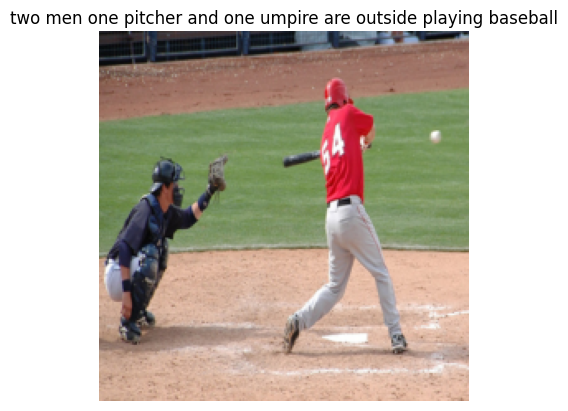

In [21]:

# Verify pipeline
def show_sample(image, caption):
    try:
        if not isinstance(image, torch.Tensor):
            raise ValueError("Image is not a torch.Tensor")
        if image.shape != (3, 224, 224):
            raise ValueError(f"Unexpected image shape: {image.shape}")
        image = image.permute(1, 2, 0).numpy()
        image = image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        image = np.clip(image, 0, 1)
        if not isinstance(caption, list) or not all(isinstance(word, str) for word in caption):
            raise ValueError(f"Invalid caption format: {caption}")
        caption_text = ' '.join(caption).strip()
        plt.imshow(image)
        plt.title(caption_text)
        plt.axis('off')
        plt.show()
    except Exception as e:
        print(f"Error in show_sample: {e}")


for batch in train_loader:
    images, captions = batch
    if images is None or captions is None:
        print("Skipping batch with None values")
        continue
    print(f"Image batch shape: {images.shape}")  # Expected: [32, 3, 224, 224]
    print(f"Sample caption: {captions[0]}")  # Expected: ['a', 'dog', 'has', ...]
    show_sample(images[0], captions[0])
    break

In [23]:

image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


def preprocess_image(image_path):
    try:
        image = Image.open(image_path).convert('RGB')
        return image_transform(image)
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None

nlp = spacy.load('en_core_web_sm')


def preprocess_caption(captions, batch_size=1000):
    # Normalize to list
    if captions is None or isinstance(captions, float):
        captions = ['']
    elif isinstance(captions, str):
        captions = [captions]
    elif not isinstance(captions, list):
        raise TypeError(f"Expected string or list, got {type(captions)}")

    # Strip and filter
    clean_captions = [str(c).strip() for c in captions
                      if isinstance(c, (str, float, int))]

    results = []
    for i in range(0, len(clean_captions), batch_size):
        batch = clean_captions[i:i + batch_size]
        docs = nlp.pipe([text.lower() for text in batch],
                        disable=['parser', 'ner'])
        for doc in docs:
            tokens = [token.text
                      for token in doc
                      if not token.is_punct and token.text.strip()]
            results.append(tokens)

    return results if len(results) > 1 else results[0]


class Flickr30kDataset(Dataset):
    def __init__(self, image_dir, annotation_file, image_transform=None):
        self.df = pd.read_csv(annotation_file, sep=',', names=['image', 'caption'], skiprows=1)
        self.image_dir = image_dir
        self.image_transform = image_transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_name = row['image']
        caption = row['caption']

        img_path = os.path.join(self.image_dir, img_name)
        image = preprocess_image(img_path)
        if image is None:
            return None

        caption_tokens = preprocess_caption(caption)
        return image, caption_tokens, img_name  # Return image name


# Custom collate function
def custom_collate_fn(batch):
    batch = [item for item in batch if item is not None]
    if len(batch) == 0:
        return None, None, None
    images, captions, image_names = zip(*batch)
    images = torch.stack(images)
    return images, captions, image_names


# Initialize dataset and splits
dataset = Flickr30kDataset(
    image_dir=r'D:\Projects\AIniverse\Scene_Description_Generator\flickr30k\versions\1\Images',
    annotation_file=r'D:\Projects\AIniverse\Scene_Description_Generator\flickr30k\versions\1\captions.txt',
    image_transform=image_transform
)

indices = np.arange(len(dataset))
np.random.seed(42)
np.random.shuffle(indices)
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]

train_subset = Subset(dataset, train_indices)
val_subset = Subset(dataset, val_indices)
test_subset = Subset(dataset, test_indices)

train_loader = DataLoader(train_subset, batch_size=32, shuffle=True, collate_fn=custom_collate_fn)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False, collate_fn=custom_collate_fn)
test_loader = DataLoader(test_subset, batch_size=32, shuffle=False, collate_fn=custom_collate_fn)

In [ ]:

# Load pre-trained ResNet-50
resnet = models.resnet50(pretrained=True).cuda()
resnet.eval()
resnet = torch.nn.Sequential(*list(resnet.children())[:-1])  # Remove final layer

# Create directory for features
feature_dir = r'D:\Projects\AIniverse\Scene_Description_Generator\flickr30k\versions\1\Features'
os.makedirs(feature_dir, exist_ok=True)


# Fixed extract_features
def extract_features(loader, split_name, subset_indices):
    features = []
    captions_list = []
    image_names = []
    for batch_idx, (images, captions, batch_image_names) in enumerate(loader):
        if images is None:
            continue
        images = images.cuda()
        with torch.no_grad():
            batch_features = resnet(images).squeeze(-1).squeeze(-1)  # [batch_size, 2048]
        features.append(batch_features.cpu())
        captions_list.extend(captions)
        image_names.extend(batch_image_names)
    features = torch.cat(features, dim=0)
    torch.save({'features': features, 'captions': captions_list, 'image_names': image_names},
               os.path.join(feature_dir, f'{split_name}_features.pt'))
    print(f"Saved {split_name} features: {features.shape}")


# Extract features
extract_features(train_loader, 'train', train_indices)
extract_features(val_loader, 'val', val_indices)
extract_features(test_loader, 'test', test_indices)

# Verify
train_features = torch.load(os.path.join(feature_dir, 'train_features.pt'))
print(f"Train feature shape: {train_features['features'].shape}")  # Expected: [127132, 2048]
print(f"Sample caption: {train_features['captions'][0]}")  # Expected: ['a', 'dog', 'has', ...]
print(f"Sample image name: {train_features['image_names'][0]}")  # Expected: e.g., 1000092795.jpg

D:\Projects\AIniverse\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\Projects\AIniverse\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:

feature_dir = r'D:\Projects\AIniverse\Scene_Description_Generator\flickr30k\versions\1\Features'

# Check if files exist
for split in ['train', 'val', 'test']:
    file_path = os.path.join(feature_dir, f'{split}_features.pt')
    if os.path.exists(file_path):
        data = torch.load(file_path)
        print(f"{split} features shape: {data['features'].shape}")
        print(f"Sample caption: {data['captions'][0]}")
        print(f"Sample image name: {data['image_names'][0]}")
    else:
        print(f"{split}_features.pt not found")

C:\Users\anmol\AppData\Local\Temp\ipykernel_14760\3049626652.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(file_path)


train features shape: torch.Size([127132, 2048])
Sample caption: ['an', 'ethnic', 'street', 'vendor', 'smiles', 'as', 'he', 'displays', 'his', 'vegetables', 'and', 'smokes', 'a', 'cigarette']
Sample image name: 97748313.jpg
val features shape: torch.Size([15891, 2048])
Sample caption: ['an', 'artist', 'is', 'painting', 'a', 'tiny', 'turtle', 'into', 'a', 'painting']
Sample image name: 4420802292.jpg
test features shape: torch.Size([15892, 2048])
Sample caption: ['two', 'people', 'are', 'in', 'a', 'pond', 'pulling', 'a', 'life', 'raft']
Sample image name: 3692746368.jpg


In [14]:


# Image preprocessing
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


def preprocess_image(image_path):
    try:
        image = Image.open(image_path).convert('RGB')
        return image_transform(image)
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None


# Caption preprocessing
nlp = spacy.load('en_core_web_sm')


def preprocess_caption(captions, batch_size=1000):
    if isinstance(captions, (str, float)):
        captions = [str(captions)]
    captions = [str(c).strip() for c in captions]
    results = []
    for i in range(0, len(captions), batch_size):
        batch = captions[i:i + batch_size]
        docs = nlp.pipe([caption.lower() for caption in batch], disable=['parser', 'ner'])
        for doc in docs:
            tokens = [token.text for token in doc if not token.is_punct and token.text.strip()]
            results.append(tokens)
    return results if len(results) > 1 else results[0]


# Dataset
class Flickr30kDataset(Dataset):
    def __init__(self, image_dir, annotation_file, image_transform=None):
        self.df = pd.read_csv(annotation_file, sep=',', names=['image', 'caption'], skiprows=1)
        self.df['caption'] = self.df['caption'].fillna('').astype(str)
        self.image_dir = image_dir
        self.image_transform = image_transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_name = row['image']
        caption = row['caption']
        img_path = os.path.join(self.image_dir, img_name)
        image = preprocess_image(img_path)
        if image is None:
            return None
        caption_tokens = preprocess_caption(caption)
        return image, caption_tokens, img_name


def custom_collate_fn(batch):
    batch = [item for item in batch if item is not None]
    if len(batch) == 0:
        return None, None, None
    images, captions, image_names = zip(*batch)
    images = torch.stack(images)
    return images, captions, image_names


# Initialize dataset and splits
dataset = Flickr30kDataset(
    image_dir=r'D:\Projects\AIniverse\Scene_Description_Generator\flickr30k\versions\1\Images',
    annotation_file=r'D:\Projects\AIniverse\Scene_Description_Generator\flickr30k\versions\1\captions.txt',
    image_transform=image_transform
)
print("Dataset loaded, size:", len(dataset))
indices = np.arange(len(dataset))
np.random.seed(42)
np.random.shuffle(indices)
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]

train_subset = Subset(dataset, train_indices)
val_subset = Subset(dataset, val_indices)
test_subset = Subset(dataset, test_indices)
print("Train subset size:", len(train_subset))
print("Val subset size:", len(val_subset))
print("Test subset size:", len(test_subset))

# Load pre-trained ViT and modify to get feature embeddings
vit = models.vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1).cuda()
vit.heads = nn.Identity()  # Remove classification head to get [batch_size, 768]
vit.eval()

# Create directory for ViT features
feature_dir = r'D:\Projects\AIniverse\Scene_Description_Generator\flickr30k\versions\1\ViT_Features'
os.makedirs(feature_dir, exist_ok=True)


# Extract ViT features
def extract_vit_features(loader, split_name):
    print(f"Starting {split_name} feature extraction")
    features = []
    captions_list = []
    image_names = []
    start_time = time.time()
    with torch.amp.autocast('cuda'), torch.no_grad():
        for batch_idx, (images, captions, batch_image_names) in enumerate(
                tqdm(loader, desc=f"Processing {split_name}")):
            if images is None:
                print(f"Skipping batch {batch_idx + 1}: No images")
                continue
            images = images.cuda()
            batch_features = vit(images)  # [batch_size, 768]
            features.append(batch_features.cpu())
            captions_list.extend(captions)
            image_names.extend(batch_image_names)
        if features:
            final_features = torch.cat(features, dim=0)
        else:
            final_features = torch.tensor([]).reshape(0, 768)
        torchsave_path = os.path.join(feature_dir, f'{split_name}_vit_features.pt')
        torch.save({
            'features': final_features,
            'captions': captions_list,
            'image_names': image_names
        }, torchsave_path)
        print(f"Saved {split_name} ViT features: {final_features.shape}")
        print(f"Time taken: {(time.time() - start_time) / 60:.2f} minutes")


# DataLoader with batch_size=32
train_loader = DataLoader(train_subset, batch_size=32, shuffle=False, collate_fn=custom_collate_fn)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False, collate_fn=custom_collate_fn)
test_loader = DataLoader(test_subset, batch_size=32, shuffle=False, collate_fn=custom_collate_fn)

# Extract features
extract_vit_features(train_loader, 'train')
extract_vit_features(val_loader, 'val')
extract_vit_features(test_loader, 'test')

# Verify
for split in ['train', 'val', 'test']:
    file_path = os.path.join(feature_dir, f'{split}_vit_features.pt')
    if os.path.exists(file_path):
        data = torch.load(file_path, weights_only=False)
        print(f"{split} features shape: {data['features'].shape}")
        print(f"Sample caption: {data['captions'][0]}")
        print(f"Sample image name: {data['image_names'][0]}")
    else:
        print(f"{split}_vit_features.pt not found")

Dataset loaded, size: 158915
Train subset size: 127132
Val subset size: 15891
Test subset size: 15892
Starting train feature extraction


Processing train: 100%|██████████| 3973/3973 [29:17<00:00,  2.26it/s]


Saved train ViT features: torch.Size([127132, 768])
Time taken: 29.33 minutes
Starting val feature extraction


Processing val: 100%|██████████| 497/497 [03:47<00:00,  2.18it/s]


Saved val ViT features: torch.Size([15891, 768])
Time taken: 3.80 minutes
Starting test feature extraction


Processing test: 100%|██████████| 497/497 [03:36<00:00,  2.30it/s]


Saved test ViT features: torch.Size([15892, 768])
Time taken: 3.61 minutes
train features shape: torch.Size([127132, 768])
Sample caption: ['a', 'man', 'is', 'sitting', 'on', 'an', 'upturned', 'white', 'bucket', 'playing', 'a', 'banjo']
Sample image name: 5797756884.jpg
val features shape: torch.Size([15891, 768])
Sample caption: ['an', 'artist', 'is', 'painting', 'a', 'tiny', 'turtle', 'into', 'a', 'painting']
Sample image name: 4420802292.jpg
test features shape: torch.Size([15892, 768])
Sample caption: ['two', 'people', 'are', 'in', 'a', 'pond', 'pulling', 'a', 'life', 'raft']
Sample image name: 3692746368.jpg


In [15]:

feature_dir = r'D:\Projects\AIniverse\Scene_Description_Generator\flickr30k\versions\1\ViT_Features'

# Check if files exist
for split in ['train', 'val', 'test']:
    file_path = os.path.join(feature_dir, f'{split}_vit_features.pt')
    if os.path.exists(file_path):
        data = torch.load(file_path)
        print(f"{split} features shape: {data['features'].shape}")
        print(f"Sample caption: {data['captions'][0]}")
        print(f"Sample image name: {data['image_names'][0]}")
    else:
        print(f"{split}_features.pt not found")

C:\Users\anmol\AppData\Local\Temp\ipykernel_42524\4241662941.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(file_path)


train features shape: torch.Size([127132, 768])
Sample caption: ['a', 'man', 'is', 'sitting', 'on', 'an', 'upturned', 'white', 'bucket', 'playing', 'a', 'banjo']
Sample image name: 5797756884.jpg
val features shape: torch.Size([15891, 768])
Sample caption: ['an', 'artist', 'is', 'painting', 'a', 'tiny', 'turtle', 'into', 'a', 'painting']
Sample image name: 4420802292.jpg
test features shape: torch.Size([15892, 768])
Sample caption: ['two', 'people', 'are', 'in', 'a', 'pond', 'pulling', 'a', 'life', 'raft']
Sample image name: 3692746368.jpg


In [ ]:

nlp = spacy.load('en_core_web_sm')


def preprocess_caption(captions, batch_size=1000):
    captions = [str(c).strip() for c in captions if not pd.isna(c)]
    results = []
    for i in range(0, len(captions), batch_size):
        batch = captions[i:i + batch_size]
        docs = nlp.pipe([caption.lower() for caption in batch], disable=['parser', 'ner'])
        for doc in docs:
            tokens = [token.text for token in doc if not token.is_punct and token.text.strip()]
            results.append(tokens)
    return results


df = pd.read_csv(r'D:\Projects\AIniverse\Scene_Description_Generator\flickr30k\versions\1\captions.txt', sep=',',
                 names=['image', 'caption'], skiprows=1)
preprocessed_captions = preprocess_caption(df['caption'].tolist())
pickle.dump(preprocessed_captions,
            open(r'D:\Projects\AIniverse\Scene_Description_Generator\flickr30k\versions\1\preprocessed_captions.pkl',
                 'wb'))



# biGRU

In [29]:
#phase4

# Vocabulary class
class Vocabulary:
    def __init__(self, min_freq=2):
        self.itos = {0: '<PAD>', 1: '<SOS>', 2: '<EOS>', 3: '<UNK>'}
        self.stoi = {'<PAD>': 0, '<SOS>': 1, '<EOS>': 2, '<UNK>': 3}
        self.min_freq = min_freq

    def build_vocabulary(self, captions):
        words = [word for caption in captions for word in caption]
        word_counts = Counter(words)
        idx = len(self.itos)
        for word, count in word_counts.items():
            if count >= self.min_freq and word not in self.stoi:
                self.itos[idx] = word
                self.stoi[word] = idx
                idx += 1

    def numericalize(self, caption):
        return [self.stoi.get(word, self.stoi['<UNK>']) for word in caption]

In [30]:

# Dataset
class Flickr30kCaptionDataset(Dataset):
    def __init__(self, feature_file, caption_file):
        data = torch.load(feature_file, weights_only=False)
        self.features = data['features']  # [num_samples, 768]
        self.captions = pickle.load(open(caption_file, 'rb'))  # List of tokenized captions
        self.image_names = data['image_names']
        self.vocab = Vocabulary(min_freq=2)
        self.vocab.build_vocabulary(self.captions)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        feature = self.features[idx]
        caption = self.captions[idx]
        numerical_caption = [self.vocab.stoi['<SOS>']] + self.vocab.numericalize(caption) + [self.vocab.stoi['<EOS>']]
        return feature, torch.tensor(numerical_caption, dtype=torch.long), self.image_names[idx]


# Custom collate function to pad captions
def custom_collate_fn(batch):
    batch = [item for item in batch if item is not None]
    if not batch:
        return None, None, None
    features, captions, image_names = zip(*batch)
    features = torch.stack(features)  # [batch_size, 768]
    # Pad captions to the longest in the batch
    max_len = max(len(c) for c in captions)
    padded_captions = torch.zeros(len(captions), max_len, dtype=torch.long)
    for i, cap in enumerate(captions):
        padded_captions[i, :len(cap)] = cap
    return features, padded_captions, image_names

In [31]:

# Bi-GRU Model
class BiGRUModel(nn.Module):
    def __init__(self, feature_dim, vocab_size, embed_dim=256, hidden_dim=512, num_layers=2, dropout=0.3):
        super(BiGRUModel, self).__init__()
        self.feature_fc = nn.Linear(feature_dim, hidden_dim)
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.gru = nn.GRU(embed_dim, hidden_dim, num_layers=num_layers, bidirectional=True, batch_first=True,
                          dropout=dropout)
        self.fc = nn.Linear(hidden_dim * 2, vocab_size)
        self.dropout = nn.Dropout(dropout)
        self.init_weights()

    def init_weights(self):
        nn.init.xavier_uniform_(self.feature_fc.weight)
        nn.init.xavier_uniform_(self.fc.weight)
        nn.init.zeros_(self.feature_fc.bias)
        nn.init.zeros_(self.fc.bias)

    def forward(self, features, captions=None):
        features = self.dropout(torch.relu(self.feature_fc(features)))  # [batch, hidden_dim]
        if captions is None:  # Inference
            batch_size = features.size(0)
            hidden = torch.zeros(2 * 2, batch_size, 512).to(features.device)
            outputs = []
            input_token = torch.full((batch_size, 1), 1, dtype=torch.long, device=features.device)  # <SOS>
            for _ in range(20):
                embed = self.embedding(input_token).squeeze(1)
                _, hidden = self.gru(embed.unsqueeze(1), hidden)
                output = self.fc(hidden[-2:].transpose(0, 1).contiguous().view(batch_size, -1))
                _, next_token = output.max(1)
                outputs.append(next_token)
                input_token = next_token.unsqueeze(1)
                if (next_token == 2).all():
                    break
            return torch.stack(outputs, dim=1)
        embed = self.embedding(captions[:, :-1])
        features = features.unsqueeze(1).repeat(1, embed.size(1), 1)
        gru_input = embed
        gru_output, _ = self.gru(gru_input)
        outputs = self.fc(self.dropout(gru_output))
        return outputs

In [32]:

# Paths
feature_dir = r'D:\Projects\AIniverse\Scene_Description_Generator\flickr30k\versions\1\ViT_Features'
caption_file = r'D:\Projects\AIniverse\Scene_Description_Generator\flickr30k\versions\1\preprocessed_captions.pkl'

# Datasets and DataLoaders
train_dataset = Flickr30kCaptionDataset(os.path.join(feature_dir, 'train_vit_features.pt'), caption_file)
val_dataset = Flickr30kCaptionDataset(os.path.join(feature_dir, 'val_vit_features.pt'), caption_file)
test_dataset = Flickr30kCaptionDataset(os.path.join(feature_dir, 'test_vit_features.pt'), caption_file)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0, collate_fn=custom_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0, collate_fn=custom_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0, collate_fn=custom_collate_fn)

In [33]:

# Model
model = BiGRUModel(
    feature_dim=768,
    vocab_size=len(train_dataset.vocab.itos),
    embed_dim=256,
    hidden_dim=512,
    num_layers=2,
    dropout=0.3
).cuda()

# Training setup
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
num_epochs = 10


In [34]:


# Training loop
def train_epoch(model, loader, criterion, optimizer):
    model.train()
    total_loss = 0
    for features, captions, _ in tqdm(loader, desc="Training"):
        if features is None:
            continue
        features, captions = features.cuda(), captions.cuda()
        outputs = model(features, captions)
        loss = criterion(outputs.view(-1, outputs.size(-1)), captions[:, 1:].contiguous().view(-1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)


# Validation loop
def validate_epoch(model, loader, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for features, captions, _ in tqdm(loader, desc="Validating"):
            if features is None:
                continue
            features, captions = features.cuda(), captions.cuda()
            outputs = model(features, captions)
            loss = criterion(outputs.view(-1, outputs.size(-1)), captions[:, 1:].contiguous().view(-1))
            total_loss += loss.item()
    return total_loss / len(loader)


# Training with early stopping
best_val_loss = float('inf')
patience = 3  # Stop if no improvement for 3 epochs
no_improve_count = 0
min_delta = 0.01  # Minimum improvement in val_loss
num_epochs = 10
for epoch in range(num_epochs):
    start_time = time.time()
    train_loss = train_epoch(model, train_loader, criterion, optimizer)
    val_loss = validate_epoch(model, val_loader, criterion)
    print(
        f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Time: {(time.time() - start_time) / 60:.2f} min")
    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss
        no_improve_count = 0
        torch.save(model.state_dict(), os.path.join(feature_dir, 'best_bigru_model.pt'))
        print(f"Saved best model with Val Loss: {best_val_loss:.4f}")
    else:
        no_improve_count += 1
        print(f"No improvement in Val Loss, count: {no_improve_count}/{patience}")
    if no_improve_count >= patience:
        print(f"Early stopping at epoch {epoch + 1}")
        break


Validating: 100%|██████████| 497/497 [00:05<00:00, 90.76it/s]


Epoch 1/100, Train Loss: 1.2350, Val Loss: 0.2221, Time: 2.69 min
Saved best model with Val Loss: 0.2221


Validating: 100%|██████████| 497/497 [00:05<00:00, 86.80it/s]


Epoch 2/100, Train Loss: 0.1447, Val Loss: 0.0655, Time: 2.74 min
Saved best model with Val Loss: 0.0655


Validating: 100%|██████████| 497/497 [00:05<00:00, 85.55it/s]


Epoch 3/100, Train Loss: 0.0570, Val Loss: 0.0273, Time: 2.76 min
Saved best model with Val Loss: 0.0273


Validating: 100%|██████████| 497/497 [00:05<00:00, 85.99it/s]


Epoch 4/100, Train Loss: 0.0288, Val Loss: 0.0128, Time: 2.77 min
Saved best model with Val Loss: 0.0128


Validating: 100%|██████████| 497/497 [00:05<00:00, 84.12it/s]


Epoch 5/100, Train Loss: 0.0159, Val Loss: 0.0062, Time: 2.79 min
No improvement in Val Loss, count: 1/3


Validating: 100%|██████████| 497/497 [00:07<00:00, 70.59it/s]


Epoch 6/100, Train Loss: 0.0090, Val Loss: 0.0032, Time: 2.84 min
No improvement in Val Loss, count: 2/3


Validating: 100%|██████████| 497/497 [00:06<00:00, 76.84it/s]


Epoch 7/100, Train Loss: 0.0054, Val Loss: 0.0017, Time: 2.91 min
Saved best model with Val Loss: 0.0017


Validating: 100%|██████████| 497/497 [00:06<00:00, 77.40it/s]


Epoch 8/100, Train Loss: 0.0034, Val Loss: 0.0009, Time: 2.92 min
No improvement in Val Loss, count: 1/3


Validating: 100%|██████████| 497/497 [00:06<00:00, 77.70it/s]


Epoch 9/100, Train Loss: 0.0022, Val Loss: 0.0004, Time: 2.91 min
No improvement in Val Loss, count: 2/3


Validating: 100%|██████████| 497/497 [00:06<00:00, 77.77it/s]

Epoch 10/100, Train Loss: 0.0014, Val Loss: 0.0002, Time: 2.91 min
No improvement in Val Loss, count: 3/3
Early stopping at epoch 10


In [47]:
best_model_path = os.path.join(feature_dir, 'best_bigru_model.pt')
model.load_state_dict(torch.load(best_model_path))
model.eval()

C:\Users\anmol\AppData\Local\Temp\ipykernel_42524\2521691121.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


BiGRUModel(
  (feature_fc): Linear(in_features=768, out_features=512, bias=True)
  (embedding): Embedding(12097, 256, padding_idx=0)
  (gru): GRU(256, 512, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (fc): Linear(in_features=1024, out_features=12097, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [ ]:
def generate_caption(model, feature, vocab, max_len=20):
    model.eval()
    with torch.no_grad():
        feature = feature.unsqueeze(0).cuda()
        batch_size = feature.size(0)

        # Initialize hidden state
        hidden = torch.zeros(2 * 2, batch_size, 512).to(feature.device)  # 4 layers (2 layers * 2 directions)

        # Start with <SOS> token
        input_token = torch.full((batch_size, 1), 1, dtype=torch.long, device=feature.device)

        # Process image features
        features = model.dropout(torch.relu(model.feature_fc(feature)))

        # Generate tokens
        tokens = []
        for _ in range(max_len):
            embed = model.embedding(input_token).squeeze(1)
            _, hidden = model.gru(embed.unsqueeze(1), hidden)
            output = model.fc(hidden[-2:].transpose(0, 1).contiguous().view(batch_size, -1))
            _, next_token = output.max(1)
            tokens.append(next_token.item())

            # Stop if <EOS> is generated
            if next_token.item() == 2:  # <EOS> token
                break

            input_token = next_token.unsqueeze(1)

        # Convert indices to words
        words = []
        for idx in tokens:
            word = vocab.itos.get(idx, '<UNK>')
            if word not in ['<SOS>', '<EOS>', '<PAD>']:
                words.append(word)

        return ' '.join(words)

In [1]:
def calculate_accuracy(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for features, captions, _ in loader:
            if features is None:
                continue

            features, captions = features.cuda(), captions.cuda()
            outputs = model(features, captions)

            # Get predictions
            _, preds = torch.max(outputs, dim=2)

            # Calculate non-padding accuracy
            mask = (captions[:, 1:] != 0)  # Ignore padding
            correct += ((preds == captions[:, 1:]) * mask).sum().item()
            total += mask.sum().item()

    return correct / total


def generate_sample_captions(model, dataset, num_samples=5):
    model.eval()
    indices = np.random.choice(len(dataset), num_samples)
    results = []

    for idx in indices:
        feature, _, image_name = dataset[idx]
        true_caption = ' '.join(dataset.captions[idx])
        gen_caption = generate_caption(model, feature, dataset.vocab)

        results.append({
            'image': image_name,
            'true': true_caption,
            'predicted': gen_caption
        })

    return results


# After training:
best_model_path = os.path.join(feature_dir, 'best_bigru_model.pt')
model.load_state_dict(torch.load(best_model_path))

# 1. Calculate token accuracy
token_accuracy = calculate_accuracy(model, test_loader)
print(f"Token-level Accuracy: {token_accuracy * 100:.2f}%")

# 2. Generate sample captions
samples = generate_sample_captions(model, test_dataset, num_samples=5)
for i, sample in enumerate(samples):
    print(f"\nSample {i + 1}:")
    print(f"Image: {sample['image']}")
    print(f"True: {sample['true']}")
    print(f"Pred: {sample['predicted']}")

# 3. Calculate BLEU score (if you want more advanced metric)
# You'll need to install: pip install torchtext
from torchtext.data.metrics import bleu_score


def calculate_bleu(model, dataset):
    model.eval()
    references = []
    candidates = []

    for i in tqdm(range(len(dataset)), desc="Calculating BLEU"):
        feature, _, _ = dataset[i]
        true_caption = dataset.captions[i]

        # Generate caption
        generated = generate_caption(model, feature, dataset.vocab)
        generated_tokens = generated.split()

        # Format for BLEU calculation
        references.append([true_caption])  # Wrap in list for multiple references
        candidates.append(generated_tokens)

    return bleu_score(candidates, references)


bleu = calculate_bleu(model, test_dataset)
print(f"BLEU Score: {bleu * 100:.2f}")

NameError: name 'os' is not defined

# TRANSFORMER

In [5]:



# Vocabulary class
class Vocabulary:
    def __init__(self, min_freq=2):
        self.itos = {0: '<PAD>', 1: '<SOS>', 2: '<EOS>', 3: '<UNK>'}
        self.stoi = {'<PAD>': 0, '<SOS>': 1, '<EOS>': 2, '<UNK>': 3}
        self.min_freq = min_freq

    def build_vocabulary(self, captions):
        words = [word for caption_list in captions.values() for caption in caption_list for word in caption]
        word_counts = Counter(words)
        idx = len(self.itos)
        for word, count in word_counts.items():
            if count >= self.min_freq and word not in self.stoi:
                self.itos[idx] = word
                self.stoi[word] = idx
                idx += 1

    def numericalize(self, caption):
        return [self.stoi.get(word, self.stoi['<UNK>']) for word in caption]

In [6]:

# Dataset
class Flickr30kCaptionDataset(Dataset):
    def __init__(self, feature_file, caption_file, augment=False):
        data = torch.load(feature_file, weights_only=False)
        self.features = data['features']
        self.image_names = data['image_names']
        self.captions_dict = pickle.load(open(caption_file, 'rb'))
        self.augment = augment
        self.vocab = Vocabulary(min_freq=2)
        self.vocab.build_vocabulary(self.captions_dict)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        feature = self.features[idx]
        image_name = self.image_names[idx]
        captions = self.captions_dict.get(image_name, [[]])
        caption = captions[torch.randint(0, len(captions), (1,)).item()] if self.augment and len(captions) > 1 else \
            captions[0]
        numerical_caption = [self.vocab.stoi['<SOS>']] + self.vocab.numericalize(caption) + [self.vocab.stoi['<EOS>']]
        return feature, torch.tensor(numerical_caption, dtype=torch.long), image_name


# Custom collate function
def custom_collate_fn(batch):
    batch = [item for item in batch if item is not None]
    if not batch:
        return None, None, None
    features, captions, image_names = zip(*batch)
    features = torch.stack(features)
    max_len = max(len(c) for c in captions)
    padded_captions = torch.zeros(len(captions), max_len, dtype=torch.long)
    for i, cap in enumerate(captions):
        padded_captions[i, :len(cap)] = cap
    return features, padded_captions, image_names

In [7]:

# Transformer Model with Beam Search
class ImageCaptionTransformer(nn.Module):
    def __init__(self, feature_dim, vocab_size, embed_dim=512, num_heads=8, num_encoder_layers=6, num_decoder_layers=6,
                 hidden_dim=2048, dropout=0.05, max_len=100):
        super(ImageCaptionTransformer, self).__init__()
        self.feature_fc = nn.Linear(feature_dim, embed_dim)  #Projects the image feature vector into Transformer embedding space.
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0) #Converts word indices into dense vectors.
        self.pos_encoder = nn.Parameter(torch.zeros(1, max_len, embed_dim)) #Learnable positional encoding

        #A stack of num_encoder_layers self-attention + feed-forward blocks, refine and contextualize the image representation using multi-head attention.
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dim_feedforward=hidden_dim,
                                                   dropout=dropout, batch_first=True)
        decoder_layer = nn.TransformerDecoderLayer(d_model=embed_dim, nhead=num_heads, dim_feedforward=hidden_dim,
                                                   dropout=dropout, batch_first=True)

        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)
        self.fc = nn.Linear(embed_dim, vocab_size) #Final output projection to vocabulary logits.
        self.embed_dim = embed_dim
        self.max_len = max_len
        self.dropout = nn.Dropout(dropout)
        self.init_weights()

    def init_weights(self):
        nn.init.xavier_uniform_(self.feature_fc.weight)
        nn.init.xavier_uniform_(self.fc.weight)
        nn.init.zeros_(self.feature_fc.bias)
        nn.init.zeros_(self.fc.bias)

    def generate_square_subsequent_mask(self, sz):
        mask = torch.triu(torch.ones(sz, sz), diagonal=1).bool()
        return mask

    def forward(self, features, captions=None, teacher_forcing_ratio=0.5):
        batch_size = features.size(0)
        device = features.device
        features = self.dropout(torch.relu(self.feature_fc(features)))
        features = features.unsqueeze(1)
        memory = self.transformer_encoder(features)
        #The encoder transforms the raw image vector into a context-aware vector (memory) that the decoder can attend to.
        if captions is None:
            return self.inference(features)
        captions = captions[:, :-1]
        embed = self.embedding(captions) * (self.embed_dim ** 0.5)
        positions = torch.arange(0, captions.size(1), device=device).unsqueeze(0).repeat(batch_size, 1)
        pos_embed = self.pos_encoder[:, :captions.size(1), :]
        embed = embed + pos_embed
        tgt_mask = self.generate_square_subsequent_mask(captions.size(1)).to(device)
        output = self.transformer_decoder(embed, memory, tgt_mask=tgt_mask)
        output = self.fc(output)
        return output

    def inference(self, features, max_len=20, beam_size=3):
        batch_size = features.size(0)
        device = features.device
        features = self.dropout(torch.relu(self.feature_fc(features)))
        features = features.unsqueeze(1)
        memory = self.transformer_encoder(features)
        sequences = [[torch.full((1, 1), 1, dtype=torch.long, device=device), 0.0]] * batch_size
        for _ in range(max_len):
            all_candidates = []
            for i in range(batch_size):
                candidates = []
                for seq, score in sequences[i]:
                    if seq[0, -1].item() == 2:
                        candidates.append([seq, score])
                        continue
                    embed = self.embedding(seq) * (self.embed_dim ** 0.5)
                    positions = torch.arange(0, seq.size(1), device=device).unsqueeze(0)
                    pos_embed = self.pos_encoder[:, :seq.size(1), :]
                    embed = embed + pos_embed
                    tgt_mask = self.generate_square_subsequent_mask(seq.size(1)).to(device)
                    output = self.transformer_decoder(embed, memory[i:i + 1], tgt_mask=tgt_mask)
                    output = self.fc(output[:, -1, :])
                    probs = torch.softmax(output, dim=-1)
                    top_probs, top_idx = probs.topk(beam_size, dim=-1)
                    for k in range(beam_size):
                        next_token = top_idx[0, k].unsqueeze(0).unsqueeze(0)
                        next_score = score - torch.log(top_probs[0, k]).item()
                        new_seq = torch.cat([seq, next_token], dim=1)
                        candidates.append([new_seq, next_score])
                candidates = sorted(candidates, key=lambda x: x[1])[:beam_size]
                all_candidates.append(candidates)
            sequences = all_candidates
        outputs = [sequences[i][0][0] for i in range(batch_size)]
        return torch.cat(outputs, dim=0)

In [ ]:

# Load original captions
def load_original_captions(caption_txt_file):
    caption_dict = {}
    try:
        with open(caption_txt_file, 'r', encoding='utf-8') as f:
            lines = f.readlines()[1:]  # Skip header
            for line in lines:
                parts = line.strip().split(',', 1)
                if len(parts) == 2:
                    image_name, caption = parts
                    caption_dict[image_name] = caption.split()
    except UnicodeDecodeError:
        with open(caption_txt_file, 'r', encoding='latin1') as f:
            lines = f.readlines()[1:]  # Skip header
            for line in lines:
                parts = line.strip().split(',', 1)
                if len(parts) == 2:
                    image_name, caption = parts
                    caption_dict[image_name] = caption.split()
    return caption_dict


# Evaluation function
def evaluate_model(model, loader, vocab, caption_dict, max_len=20, num_samples=5, beam_size=3):
    model.eval()
    references, hypotheses = [], []
    sample_outputs = []

    with torch.no_grad():
        for batch_idx, (features, captions, image_names) in enumerate(tqdm(loader, desc="Evaluating")):
            if features is None:
                continue
            features, captions = features.cuda(), captions.cuda()
            outputs = model.inference(features, max_len=max_len, beam_size=beam_size)
            for i in range(captions.size(0)):
                image_name = image_names[i]
                ref = caption_dict.get(image_name,
                                       [vocab.itos[idx.item()] for idx in captions[i] if idx.item() not in [0, 1, 2]])
                hyp = [vocab.itos[idx.item()] for idx in outputs[i] if idx.item() not in [0, 1, 2]]
                references.append([ref])
                hypotheses.append(hyp)
                if len(sample_outputs) < num_samples and batch_idx * captions.size(0) + i < num_samples:
                    sample_outputs.append({
                        'image_name': image_name,
                        'ground_truth': ' '.join(ref),
                        'generated': ' '.join(hyp)
                    })
    smoothing = SmoothingFunction().method1
    bleu_score = corpus_bleu(references, hypotheses, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothing)
    return bleu_score, sample_outputs

In [ ]:

# Paths
feature_dir = r'D:\Projects\AIniverse\Scene_Description_Generator\flickr30k\versions\1\ViT_Features'
caption_file = r'D:\Projects\AIniverse\Scene_Description_Generator\flickr30k\versions\1\preprocessed_captions1.pkl'
caption_txt_file = r'D:\Projects\AIniverse\Scene_Description_Generator\flickr30k\versions\1\captions.txt'

# Datasets and DataLoaders
train_dataset = Flickr30kCaptionDataset(os.path.join(feature_dir, 'train_vit_features.pt'), caption_file, augment=True)
val_dataset = Flickr30kCaptionDataset(os.path.join(feature_dir, 'val_vit_features.pt'), caption_file, augment=False)
test_dataset = Flickr30kCaptionDataset(os.path.join(feature_dir, 'test_vit_features.pt'), caption_file, augment=False)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0, collate_fn=custom_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0, collate_fn=custom_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0, collate_fn=custom_collate_fn)

# Save vocab
with open(os.path.join(feature_dir, 'vocab.pkl'), 'wb') as f:
    pickle.dump(train_dataset.vocab, f)
print(f"Saved vocab.pkl with {len(train_dataset.vocab.itos)} tokens")

# Model
model = ImageCaptionTransformer(
    feature_dim=768,
    vocab_size=len(train_dataset.vocab.itos),
    embed_dim=512,
    num_heads=8,
    num_encoder_layers=6,
    num_decoder_layers=6,
    hidden_dim=2048,
    dropout=0.05,
    max_len=100
).cuda()

In [ ]:

# Training setup
criterion = nn.CrossEntropyLoss(ignore_index=0, label_smoothing=0.1)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30, eta_min=1e-6)
num_epochs = 100


# Training loop
def train_epoch(model, loader, criterion, optimizer, teacher_forcing_ratio=0.5):
    model.train()
    total_loss = 0
    for features, captions, _ in tqdm(loader, desc="Training"):
        if features is None:
            continue
        features, captions = features.cuda(), captions.cuda()
        outputs = model(features, captions, teacher_forcing_ratio)
        loss = criterion(outputs.view(-1, outputs.size(-1)), captions[:, 1:].contiguous().view(-1))
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)


# Validation loop
def validate_epoch(model, loader, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for features, captions, _ in tqdm(loader, desc="Validating"):
            if features is None:
                continue
            features, captions = features.cuda(), captions.cuda()
            outputs = model(features, captions, teacher_forcing_ratio=1.0)
            loss = criterion(outputs.view(-1, outputs.size(-1)), captions[:, 1:].contiguous().view(-1))
            total_loss += loss.item()
    return total_loss / len(loader)


# Training with early stopping
best_val_loss = float('inf')
patience = 3
no_improve_count = 0
min_delta = 0.01
for epoch in range(num_epochs):
    start_time = time.time()
    train_loss = train_epoch(model, train_loader, criterion, optimizer, teacher_forcing_ratio=0.5)
    val_loss = validate_epoch(model, val_loader, criterion)
    scheduler.step()
    print(
        f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Time: {(time.time() - start_time) / 60:.2f} min, LR: {optimizer.param_groups[0]['lr']:.6f}")
    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss
        no_improve_count = 0
        torch.save(model.state_dict(), os.path.join(feature_dir, 'best_transformer_model.pt'))
        print(f"Saved best model with Val Loss: {best_val_loss:.4f}")
    else:
        no_improve_count += 1
        print(f"No improvement in Val Loss, count: {no_improve_count}/{patience}")
    if no_improve_count >= patience:
        print(f"Early stopping at epoch {epoch + 1}")
        break

# Epoch 33/100, Train Loss: 2.3750, Val Loss: 2.3233, Time: 7.71 min, LR: 0.000003
# No improvement in Val Loss, count: 3/3
# Early stopping at epoch 33

# Testing evaluate

In [8]:



# Vocabulary class (unchanged)
class Vocabulary:
    def __init__(self, min_freq=2):
        self.itos = {0: '<PAD>', 1: '<SOS>', 2: '<EOS>', 3: '<UNK>'}
        self.stoi = {'<PAD>': 0, '<SOS>': 1, '<EOS>': 2, '<UNK>': 3}
        self.min_freq = min_freq

    def build_vocabulary(self, captions):
        words = [word for caption_list in captions.values() for caption in caption_list for word in caption]
        word_counts = Counter(words)
        idx = len(self.itos)
        for word, count in word_counts.items():
            if count >= self.min_freq and word not in self.stoi:
                self.itos[idx] = word
                self.stoi[word] = idx
                idx += 1

    def numericalize(self, caption):
        return [self.stoi.get(word, self.stoi['<UNK>']) for word in caption]


# Dataset (unchanged)
class Flickr30kCaptionDataset(Dataset):
    def __init__(self, feature_file, caption_file, augment=False):
        data = torch.load(feature_file, weights_only=False)
        self.features = data['features']
        self.image_names = data['image_names']
        self.captions_dict = pickle.load(open(caption_file, 'rb'))
        self.augment = augment
        self.vocab = Vocabulary(min_freq=2)
        self.vocab.build_vocabulary(self.captions_dict)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        feature = self.features[idx]
        image_name = self.image_names[idx]
        captions = self.captions_dict.get(image_name, [[]])
        caption = captions[torch.randint(0, len(captions), (1,)).item()] if self.augment and len(captions) > 1 else \
            captions[0]
        numerical_caption = [self.vocab.stoi['<SOS>']] + self.vocab.numericalize(caption) + [self.vocab.stoi['<EOS>']]
        return feature, torch.tensor(numerical_caption, dtype=torch.long), image_name


# Custom collate function (unchanged)
def custom_collate_fn(batch):
    batch = [item for item in batch if item is not None]
    if not batch:
        return None, None, None
    features, captions, image_names = zip(*batch)
    features = torch.stack(features)
    max_len = max(len(c) for c in captions)
    padded_captions = torch.zeros(len(captions), max_len, dtype=torch.long)
    for i, cap in enumerate(captions):
        padded_captions[i, :len(cap)] = cap
    return features, padded_captions, image_names


# Transformer Model with Greedy Inference (to match best_transformer_model.pt)
class ImageCaptionTransformer(nn.Module):
    def __init__(self, feature_dim, vocab_size, embed_dim=512, num_heads=8, num_encoder_layers=6, num_decoder_layers=6,
                 hidden_dim=2048, dropout=0.05, max_len=100):
        super(ImageCaptionTransformer, self).__init__()
        self.feature_fc = nn.Linear(feature_dim, embed_dim)
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.pos_encoder = nn.Parameter(torch.zeros(1, max_len, embed_dim))
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dim_feedforward=hidden_dim,
                                                   dropout=dropout, batch_first=True)
        decoder_layer = nn.TransformerDecoderLayer(d_model=embed_dim, nhead=num_heads, dim_feedforward=hidden_dim,
                                                   dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)
        self.fc = nn.Linear(embed_dim, vocab_size)
        self.embed_dim = embed_dim
        self.max_len = max_len
        self.dropout = nn.Dropout(dropout)
        self.init_weights()

    def init_weights(self):
        nn.init.xavier_uniform_(self.feature_fc.weight)
        nn.init.xavier_uniform_(self.fc.weight)
        nn.init.zeros_(self.feature_fc.bias)
        nn.init.zeros_(self.fc.bias)

    def generate_square_subsequent_mask(self, sz):
        mask = torch.triu(torch.ones(sz, sz), diagonal=1).bool()
        return mask

    def forward(self, features, captions=None, teacher_forcing_ratio=0.5):
        batch_size = features.size(0)
        device = features.device
        features = self.dropout(torch.relu(self.feature_fc(features)))
        features = features.unsqueeze(1)
        memory = self.transformer_encoder(features)
        if captions is None:
            return self.inference(features)
        captions = captions[:, :-1]
        embed = self.embedding(captions) * (self.embed_dim ** 0.5)
        positions = torch.arange(0, captions.size(1), device=device).unsqueeze(0).repeat(batch_size, 1)
        pos_embed = self.pos_encoder[:, :captions.size(1), :]
        embed = embed + pos_embed
        tgt_mask = self.generate_square_subsequent_mask(captions.size(1)).to(device)
        output = self.transformer_decoder(embed, memory, tgt_mask=tgt_mask)
        output = self.fc(output)
        return output

    def inference(self, features, max_len=20):
        batch_size = features.size(0)
        device = features.device
        features = self.dropout(torch.relu(self.feature_fc(features)))
        features = features.unsqueeze(1)
        memory = self.transformer_encoder(features)
        outputs = []
        input_token = torch.full((batch_size, 1), 1, dtype=torch.long, device=device)
        for _ in range(max_len):
            embed = self.embedding(input_token) * (self.embed_dim ** 0.5)
            positions = torch.arange(0, input_token.size(1), device=device).unsqueeze(0).repeat(batch_size, 1)
            pos_embed = self.pos_encoder[:, :input_token.size(1), :]
            embed = embed + pos_embed
            tgt_mask = self.generate_square_subsequent_mask(input_token.size(1)).to(device)
            output = self.transformer_decoder(embed, memory, tgt_mask=tgt_mask)
            output = self.fc(output[:, -1, :])
            _, next_token = output.max(1)
            outputs.append(next_token)
            input_token = torch.cat([input_token, next_token.unsqueeze(1)], dim=1)
            if (next_token == 2).all():
                break
        return torch.stack(outputs, dim=1)


# Load original captions
def load_original_captions(caption_txt_file):
    caption_dict = {}
    try:
        with open(caption_txt_file, 'r', encoding='utf-8') as f:
            lines = f.readlines()[1:]  # Skip header
            for line in lines:
                parts = line.strip().split(',', 1)
                if len(parts) == 2:
                    image_name, caption = parts
                    caption_dict[image_name] = caption.split()
    except UnicodeDecodeError:
        with open(caption_txt_file, 'r', encoding='latin1') as f:
            lines = f.readlines()[1:]  # Skip header
            for line in lines:
                parts = line.strip().split(',', 1)
                if len(parts) == 2:
                    image_name, caption = parts
                    caption_dict[image_name] = caption.split()
    return caption_dict


# Evaluation function (updated for greedy decoding)
def evaluate_model(model, loader, vocab, caption_dict, max_len=20, num_samples=5):
    model.eval()
    references, hypotheses = [], []
    sample_outputs = []

    with torch.no_grad():
        for batch_idx, (features, captions, image_names) in enumerate(tqdm(loader, desc="Evaluating")):
            if features is None:
                continue
            features, captions = features.cuda(), captions.cuda()
            outputs = model.inference(features, max_len=max_len)  # Greedy decoding
            for i in range(captions.size(0)):
                image_name = image_names[i]
                ref = caption_dict.get(image_name,
                                       [vocab.itos[idx.item()] for idx in captions[i] if idx.item() not in [0, 1, 2]])
                hyp = [vocab.itos[idx.item()] for idx in outputs[i] if idx.item() not in [0, 1, 2]]
                references.append([ref])
                hypotheses.append(hyp)
                if len(sample_outputs) < num_samples and batch_idx * captions.size(0) + i < num_samples:
                    sample_outputs.append({
                        'image_name': image_name,
                        'ground_truth': ' '.join(ref),
                        'generated': ' '.join(hyp)
                    })
    smoothing = SmoothingFunction().method1
    bleu_score = corpus_bleu(references, hypotheses, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothing)
    return bleu_score, sample_outputs


# Paths
feature_dir = r'D:\Projects\AIniverse\Scene_Description_Generator\flickr30k\versions\1\ViT_Features'
caption_file = r'D:\Projects\AIniverse\Scene_Description_Generator\flickr30k\versions\1\preprocessed_captions1.pkl'
caption_txt_file = r'D:\Projects\AIniverse\Scene_Description_Generator\flickr30k\versions\1\captions.txt'

# Load original captions
caption_dict = load_original_captions(caption_txt_file)

# Datasets and DataLoaders
val_dataset = Flickr30kCaptionDataset(os.path.join(feature_dir, 'val_vit_features.pt'), caption_file, augment=False)
test_dataset = Flickr30kCaptionDataset(os.path.join(feature_dir, 'test_vit_features.pt'), caption_file, augment=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0, collate_fn=custom_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0, collate_fn=custom_collate_fn)

# Load vocabulary
vocab = pickle.load(open(os.path.join(feature_dir, 'vocab.pkl'), 'rb'))
print(f"Loaded vocab.pkl with {len(vocab.itos)} tokens")

# Initialize model
model = ImageCaptionTransformer(
    feature_dim=768,
    vocab_size=len(vocab.itos),
    embed_dim=512,
    num_heads=8,
    num_encoder_layers=6,
    num_decoder_layers=6,
    hidden_dim=2048,
    dropout=0.05,
    max_len=100
).cuda()

# Load trained model weights
model_path = os.path.join(feature_dir, 'best_transformer_model.pt')
model.load_state_dict(torch.load(model_path))

# Evaluate on validation and test sets
val_bleu, val_samples = evaluate_model(model, val_loader, vocab, caption_dict, max_len=20, num_samples=10)
test_bleu, test_samples = evaluate_model(model, test_loader, vocab, caption_dict, max_len=20, num_samples=10)

# Print results
print(f"\nValidation BLEU-4 Score: {val_bleu:.4f}")
print("\nValidation Sample Outputs:")
for sample in val_samples:
    print(f"Image: {sample['image_name']}")
    print(f"Ground Truth: {sample['ground_truth']}")
    print(f"Generated: {sample['generated']}\n")

for sample in test_samples:
    print(f"Image: {sample['image_name']}")
    print(f"Ground Truth: {sample['ground_truth']}")
    print(f"Generated: {sample['generated']}\n")

# Debug: Verify caption alignment
print("\nSample Caption.txt Verification:")
for i, image_name in enumerate(list(caption_dict.keys())[:5]):
    print(f"Image {i + 1}: {image_name}, Caption: {' '.join(caption_dict[image_name])}")

# Debug: Verify vocabulary
print(f"\nSample Vocab Tokens: {list(vocab.itos.items())[:10]}")

Loaded vocab.pkl with 12097 tokens


Evaluating: 100%|██████████| 497/497 [01:55<00:00,  4.31it/s]



Validation BLEU-4 Score: 0.0862

Validation Sample Outputs:
Image: 4420802292.jpg
Ground Truth: A man concentrates to paint details .
Generated: a man with a green cap and a white long sleeve shirt is painting a picture of a building with

Image: 1579291454.jpg
Ground Truth: Priests reading prayers from note cards .
Generated: a man in a white robe is reading from a book to another man in a white robe

Image: 3720366614.jpg
Ground Truth: The dog is jumping up beside a red wall .
Generated: a dog is jumping up to catch a toy while another dog watches

Image: 2315113960.jpg
Ground Truth: A woman at an exhibit faces away from a camera .
Generated: a woman is looking at a photograph

Image: 2785408815.jpg
Ground Truth: a man smiling in a white coat .
Generated: a man in a lab coat is smiling with a large smile on his face

Image: 4565079276.jpg
Ground Truth: A woman riding a bicycle .
Generated: a woman wearing a black jacket rides a red bicycle down the street

Image: 228280436.jpg
Groun